In [2]:
%pylab inline
import scipy.stats
from collections import defaultdict
import numpy as np
import tools as t
import pandas as pd
from datetime import datetime, date, time
import os


Populating the interactive namespace from numpy and matplotlib


C:\Users\lenovo\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
def nested_dict_factory(): 
    return defaultdict(int)
def nested_dict_factory2():
    return defaultdict(nested_dict_factory)

In [4]:
cluster=pd.read_table("training_data/cluster_map/cluster_map",header=None)
cluster=np.asarray(cluster)

C:\Users\lenovo\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [5]:
file1=open('training_data/poi_data/poi_data','r')
a=(file1.read())
lines=a.splitlines()
poi=[[],[]]
for templine in lines:
    t1=templine.split('\t')
    dictpoi = defaultdict(nested_dict_factory2)
    for x in range(1,len(t1)):
        cls_sub_count=t1[x].split('#')
        if len(cls_sub_count)>1:
            cls=cls_sub_count[0]
            sub_counts=cls_sub_count[1]
        else:
            sub_counts=cls_sub_count[0]
        
        sub,count=sub_counts.split(':')
        #print cls,sub,count
        dictpoi[cls][sub]=count
    maxcls=0
    totalsum=0
    for xd1 in dictpoi.iterkeys():
        intxd1=int(xd1)
        if maxcls<intxd1:
            maxcls=intxd1
    maxcls+=1

    for xd1 in dictpoi.iterkeys():
        for xd2 in dictpoi[xd1].iterkeys():
            totalsum+=(maxcls-int(xd1))*int(xd2)*int(dictpoi[xd1][xd2])
    poi[1].append(totalsum)
    poi[0].append(t1[0])
poi=np.array(poi).T
poi=np.hstack((poi,np.zeros((poi.shape[0],1),dtype=np.int16)))


In [6]:
for x in range(66):
    mask=poi[:,0]==cluster[x][0]
    poi[x,2]=np.squeeze(np.where(mask==True,))+1

In [11]:
def get_matrix(path_data):
    
    names=[]
    matrix=[]
    fl=0
    pathstemp=os.listdir(path_data+'/order_data/')
    paths=sorted([x for x in pathstemp if x[0:2]!='._'])
    for x1 in paths:
        print x1
        fl+=1
        name=x1[19:21:1]
        names.append(name)
        order_data=pd.read_table(path_data+"/order_data/order_data_2016-01-"+name,header=None)
        order_data=order_data.fillna(0)
        order_data=np.asarray(order_data[[1,3,6]].dropna())
        for x in range(cluster.shape[0]):
            mask=cluster[x][0]==order_data[:,1]
            order_data[mask,1]=cluster[x][1]
        mask=order_data[:,0]!=0
        order_data[mask,0]=1
        dict1 = defaultdict(nested_dict_factory2)
        a=np.datetime64(order_data[0,2])
        a=a.astype(datetime)
        dow=a.isoweekday()
        for x in range(order_data.shape[0]):
            a=np.datetime64(order_data[x,2], 'us')
            #datetime(a)
            a=a.astype(datetime)

            slot=(a.hour*6)+(a.minute/10)
            dict1[order_data[x,1]][slot]['total']+=1
            if order_data[x,0]==1:
                dict1[order_data[x,1]][slot]['supply']+=1
        weather_data=pd.read_table(path_data+"/weather_data/weather_data_2016-01-"+name,header=None)
        weather_data=np.asarray(weather_data)
        listx=[[],[],[],[],[]]
        for k2 in range(144):
            for k1 in range(1,67):
                listx[0].append(k1)
                listx[1].append(k2)
                listx[2].append(dow)
                listx[3].append(dict1[k1][k2]['total'])
                listx[4].append(dict1[k1][k2]['supply'])
        nparr=np.array(listx)
        nparr=nparr.T
        nparr=np.hstack((nparr,np.zeros((nparr.shape[0],3),dtype=np.float32)))
        strt=0
        en=0
        lslot=0
        meanw=np.mean(weather_data[:,1:],axis=0)
        a=np.datetime64(weather_data[0,0])
        a=a.astype(datetime)
        prevslot=(a.hour*6)+(a.minute/10)
        startindex=0
        endindex=0
        for x in range(1,weather_data.shape[0]-1):
            nexttime=np.datetime64(weather_data[x,0]).astype(datetime)
            nextslot=(nexttime.hour*6)+(nexttime.minute/10)

            if prevslot!=nextslot:
                endindex=x-1
                indexes=np.where(nparr[:,1]==prevslot)
                nparr[indexes,5:]=np.mean(weather_data[startindex:endindex+1,1:],axis=0)

                startindex=endindex+1
                prevslot=nextslot
        indexes=np.where(nparr[:,6]==0)
        nparr[indexes,5:]=meanw

        gap=nparr[:,3]-nparr[:,4]
        gap=np.reshape(gap,(gap.shape[0],1))
        nparr=np.hstack((nparr,gap)) 
        if fl==1:
            matrix=nparr
        else:
            matrix=np.vstack((matrix,nparr))
        del nparr
        del dict1
        del listx
    return matrix
    

In [12]:
matrix=get_matrix("training_data")

order_data_2016-01-01


C:\Users\lenovo\Anaconda2\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  del sys.path[0]
C:\Users\lenovo\Anaconda2\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


order_data_2016-01-02
order_data_2016-01-03
order_data_2016-01-04
order_data_2016-01-05
order_data_2016-01-06
order_data_2016-01-07
order_data_2016-01-08
order_data_2016-01-09
order_data_2016-01-10
order_data_2016-01-11
order_data_2016-01-12
order_data_2016-01-13
order_data_2016-01-14
order_data_2016-01-15
order_data_2016-01-16
order_data_2016-01-17
order_data_2016-01-18
order_data_2016-01-19
order_data_2016-01-20
order_data_2016-01-21


In [13]:
data=pd.read_csv('./dataX.csv',delimiter=',')

In [14]:
matrix=np.hstack((matrix,np.zeros((matrix.shape[0],1),dtype=np.float16)))
for x in poi:
    indmask=np.where(matrix[:,0]==int(x[2]))
    matrix[indmask,9]=x[1]

In [15]:
print matrix.shape

(199584L, 10L)


In [16]:
data=pd.DataFrame(matrix)

data.to_csv("dataX.csv",sep=',',index=False)

In [17]:

data.describe()


,0,1,2,3,4,5,6,7,8,9
count,199584.00000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,1.995840e+05
mean,33.50000,71.500000,4.000000,42.791962,35.193873,3.040489,6.187362,119.630532,7.598089,3.973977e+07
std,19.05042,41.568321,2.000005,103.652036,75.187376,1.555854,3.700350,50.409283,45.229444,6.727068e+07
min,1.00000,0.000000,1.000000,0.000000,0.000000,1.000000,0.500000,26.000000,0.000000,4.233830e+05
25%,17.00000,35.750000,2.000000,1.000000,1.000000,2.000000,3.000000,84.000000,0.000000,7.747552e+06
50%,33.50000,71.500000,4.000000,7.000000,6.000000,2.680851,6.000000,115.000000,1.000000,1.540297e+07
75%,50.00000,107.250000,6.000000,32.000000,28.000000,4.000000,8.000000,153.148387,3.000000,3.866538e+07
max,66.00000,143.000000,7.000000,4362.000000,1084.000000,9.000000,19.000000,276.000000,3872.000000,4.350724e+08


In [21]:
np.savetxt('dataX.csv',matrix,delimiter=',')

In [22]:
martix=np.fromfile('dataX.csv',sep=',')

In [23]:
data.describe()

,0,1,2,3,4,5,6,7,8,9
count,199584.00000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,1.995840e+05
mean,33.50000,71.500000,4.000000,42.791962,35.193873,3.040489,6.187362,119.630532,7.598089,3.973977e+07
std,19.05042,41.568321,2.000005,103.652036,75.187376,1.555854,3.700350,50.409283,45.229444,6.727068e+07
min,1.00000,0.000000,1.000000,0.000000,0.000000,1.000000,0.500000,26.000000,0.000000,4.233830e+05
25%,17.00000,35.750000,2.000000,1.000000,1.000000,2.000000,3.000000,84.000000,0.000000,7.747552e+06
50%,33.50000,71.500000,4.000000,7.000000,6.000000,2.680851,6.000000,115.000000,1.000000,1.540297e+07
75%,50.00000,107.250000,6.000000,32.000000,28.000000,4.000000,8.000000,153.148387,3.000000,3.866538e+07
max,66.00000,143.000000,7.000000,4362.000000,1084.000000,9.000000,19.000000,276.000000,3872.000000,4.350724e+08


In [24]:
matrix=np.array(data)

In [25]:
def get_test_matrix(path_data):
    
    names=[]
    matrix=[]
    fl=0
    pathstemp=os.listdir(path_data+'/order_data/')
    paths=sorted([x for x in pathstemp if x[0:2]!='._'])
    for x1 in paths:
        print x1
        fl+=1
        name=x1[19:21:1]
        names.append(name)
        order_data=pd.read_csv(path_data+"/order_data/order_data_2016-01-"+name,header=None)
        #print order_data
        order_data=order_data.fillna(0)
        order_data=np.asarray(order_data[[2,4]].dropna())
        #print order_data.shape
        for x in range(cluster.shape[0]):
            mask=cluster[x][0]==order_data[:,0]
            order_data[mask,0]=cluster[x][1]
        #return order_data
        dict1 = defaultdict(nested_dict_factory2)
        a=np.datetime64(order_data[0,1])
        a=a.astype(datetime)
        dow=a.isoweekday()
        for x in range(order_data.shape[0]):
            a=np.datetime64(order_data[x,1])
            #datetime(a)
            a=a.astype(datetime)
            
            slot=(a.hour*6)+(a.minute/10)
            dict1[order_data[x,0]][slot]['total']+=1
            #print "region",order_data[x,0],"slot",slot
        #return dict1
        weather_data=pd.read_table(path_data+"/weather_data/weather_data_2016-01-"+name,header=None)
        weather_data=np.asarray(weather_data)
        listx=[[],[],[],[]]
        for k2 in range(144):
            for k1 in range(1,67):

                listx[0].append(k1)
                listx[1].append(k2)
                listx[2].append(dow)
                listx[3].append(dict1[k1][k2]['total'])
        nparr=np.array(listx)
        nparr=nparr.T
        #return weather_data
        nparr=np.hstack((nparr,np.zeros((nparr.shape[0],3),dtype=np.float32)))
        strt=0
        en=0
        lslot=0
        meanw=np.mean(weather_data[:,1:],axis=0)
        a=np.datetime64(weather_data[0,0])
        a=a.astype(datetime)
        prevslot=(a.hour*6)+(a.minute/10)
        startindex=0
        endindex=0
        for x in range(1,weather_data.shape[0]-1):
            nexttime=np.datetime64(weather_data[x,0]).astype(datetime)
            nextslot=(nexttime.hour*6)+(nexttime.minute/10)

            if prevslot!=nextslot:
                endindex=x-1
                indexes=np.where(nparr[:,1]==prevslot)
                nparr[indexes,4:]=np.mean(weather_data[startindex:endindex+1,1:],axis=0)

                startindex=endindex+1
                prevslot=nextslot
        indexes=np.where(nparr[:,4]==0)
        nparr[indexes,4:]=meanw
        #return nparr

        #gap=nparr[:,3]-nparr[:,4]
        #gap=np.reshape(gap,(gap.shape[0],1))
        #nparr=np.hstack((nparr,gap)) 
        if fl==1:
            matrix=nparr
        else:
            matrix=np.vstack((matrix,nparr))
        del nparr
        del dict1
        del listx
    return matrix

In [26]:
TestData=get_test_matrix("test_set")

order_data_2016-01-23


C:\Users\lenovo\Anaconda2\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


order_data_2016-01-25
order_data_2016-01-27
order_data_2016-01-29
order_data_2016-01-31


In [27]:
TestData=np.hstack((TestData,np.zeros((TestData.shape[0],1),dtype=np.float32)))
for x in poi:
    indmask=np.where(TestData[:,0]==int(x[2]))
    TestData[indmask,7]=x[1]
    #print indmask,

In [28]:
testd=pd.DataFrame(TestData)
#testd.to_csv('testdata.csv',sep=',',index=False)
testd.describe()

,0,1,2,3,4,5,6,7
count,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000,4.752000e+04
mean,33.500000,71.500000,4.400000,11.681881,2.956595,1.780635,65.375667,3.973977e+07
std,19.050572,41.568654,2.154089,64.389835,1.197576,2.447707,17.491216,6.727122e+07
min,1.000000,0.000000,1.000000,0.000000,1.000000,-6.000000,29.000000,4.233830e+05
25%,17.000000,35.750000,3.000000,0.000000,2.545455,0.125000,55.125000,7.747552e+06
50%,33.500000,71.500000,5.000000,0.000000,2.958333,2.000000,59.727273,1.540297e+07
75%,50.000000,107.250000,6.000000,0.000000,3.529412,4.208333,81.894737,3.866538e+07
max,66.000000,143.000000,7.000000,1876.000000,8.000000,6.000000,117.000000,4.350724e+08


In [29]:
print TestData.shape
print matrix.shape

(47520L, 8L)
(199584L, 10L)


In [30]:
def append_isweekend(mat):
    mat=np.hstack((mat,np.zeros((mat.shape[0],1),dtype=np.float32)))
    mask=np.logical_or(mat[:,2]==6,mat[:,2]==7)
    mat[mask,-1]=1
    return mat

In [31]:
#matrix=append_isweekend(np.asarray(matrix))
#TestData=append_isweekend(np.asarray(TestData))
matrix=np.asarray(matrix)
TestData=np.asarray(TestData)

In [32]:
#Xdata=matrix[:,[0,1,2,3,5,6,7,9,10]]
Xdata=matrix[:,[0,1,2,3,5,7,9]]
Ydata=matrix[:,8]

In [33]:
#testData=TestData[:,[0,1,2,3,4,5,6,7,8]]
testData=TestData[:,[0,1,2,3,4,6,7]]

In [36]:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, Ydata,test_size=0.30)

In [37]:
from sklearn.ensemble import RandomForestRegressor

# Absolute Mean Error of Random Forest

In [38]:

model=RandomForestRegressor(random_state=0,n_estimators=50,max_depth=17)
model.fit(Xtrain, ytrain)
y_test = model.predict(Xtest)

print np.mean(np.abs(y_test-ytest))

2.125659653720778


In [39]:
print ytest.shape,y_test.shape

(59876L,) (59876L,)


Text(0.5,1,'Actual results overall')

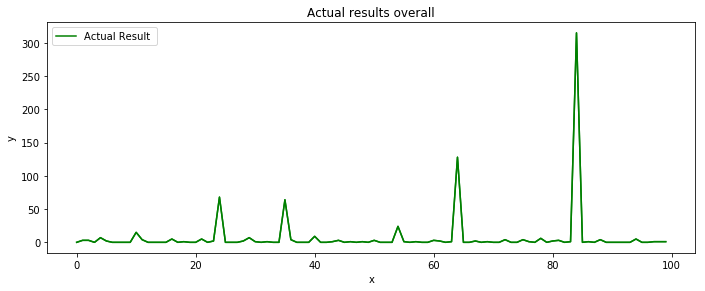

In [40]:
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 1.5, 0.8]) # left, bottom, width, height (range 0 to 1)


axes.plot( np.arange(100),ytest[0:100], 'g')
axes.plot( np.arange(100),ytest[0:100],'g', label="Actual Result ")

axes.legend(loc=2); # upper left corner
axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('Actual results overall')

Text(0.5,1,'Predict result overall')

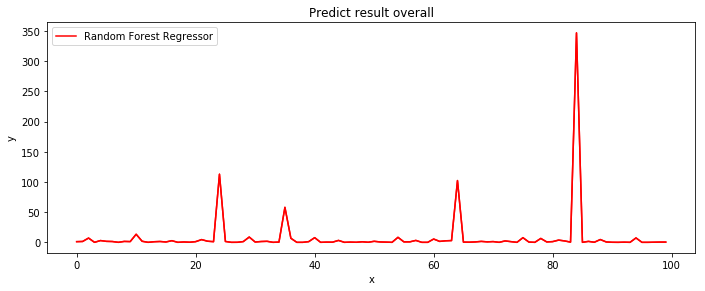

In [41]:
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 1.5, 0.8]) # left, bottom, width, height (range 0 to 1)

axes.plot( np.arange(100),y_test[0:100], 'r')

axes.plot( np.arange(100),y_test[0:100],'r', label="Random Forest Regressor")

axes.legend(loc=2); # upper left corner

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('Predict result overall')

Text(0.5,1,'combine actual $ Predict')

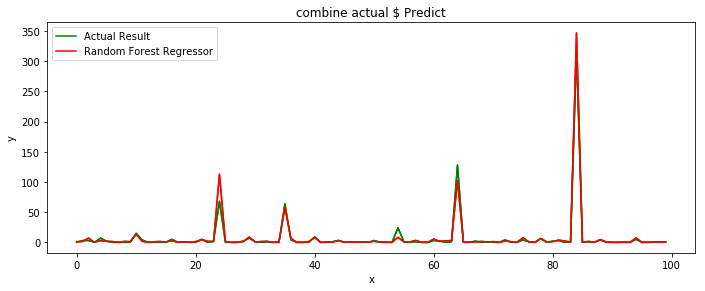

In [42]:
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 1.5, 0.8]) # left, bottom, width, height (range 0 to 1)

axes.plot( np.arange(100),y_test[0:100], 'r')
axes.plot( np.arange(100),ytest[0:100], 'g')
axes.plot( np.arange(100),ytest[0:100],'g', label="Actual Result ")
axes.plot( np.arange(100),y_test[0:100],'r', label="Random Forest Regressor")

axes.legend(loc=2); # upper left corner
axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('combine actual $ Predict')

Text(0.5,1,'Specific Day Specific Area')

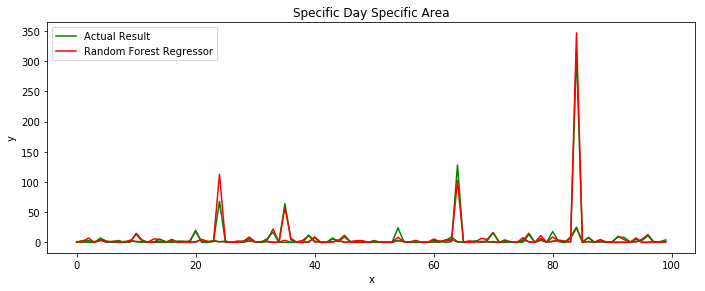

In [43]:
m1=Xtest[:,0]==6
m2=Xtest[:,2]==1
mt=np.logical_and(m1,m2)
#print Xtest[mt]
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 1.5, 0.8]) # left, bottom, width, height (range 0 to 1)

axes.plot( np.arange(100),y_test[mt][:100], 'r')
axes.plot( np.arange(100),ytest[mt][:100], 'g')

axes.plot( np.arange(100),ytest[0:100],'g', label="Actual Result ")
axes.plot( np.arange(100),y_test[0:100],'r', label="Random Forest Regressor")

axes.legend(loc=2); # upper left corner
axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('Specific Day Specific Area')

In [44]:
#print Xtest[idx][:10]

Text(0.5,1,'Specific Area')

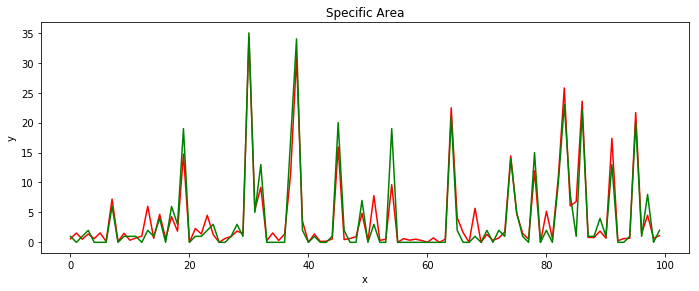

In [45]:
idx=np.where(Xtest[:,0]==6)
d1=Xtest[idx]
#print d1[:50,0]
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 1.5, 0.8]) # left, bottom, width, height (range 0 to 1)
 

    
axes.plot( np.arange(100),y_test[idx][:100], 'r')
axes.plot( np.arange(100),ytest[idx][:100], 'g')

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('Specific Area')

Text(0.5,1,'Specific Time')

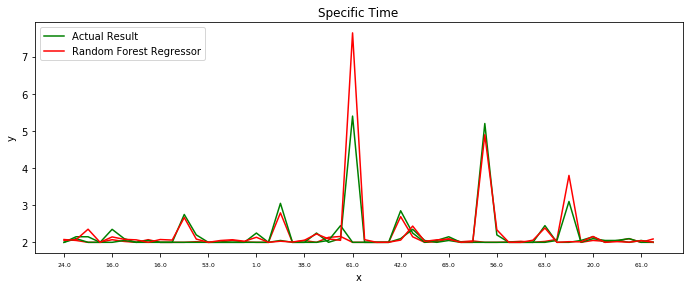

In [46]:
idx=np.where(Xtest[:,1]==12)
d1=Xtest[idx]



fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 1.5, 0.8]) # left, bottom, width, height (range 0 to 1)

axes.plot( np.arange(50),y_test[idx][:50], 'r')
axes.plot( np.arange(50),ytest[idx][:50], 'g')

axes.plot( np.arange(50),ytest[0:50],'g', label="Actual Result ")
axes.plot( np.arange(50),y_test[0:50],'r', label="Random Forest Regressor")

axes.legend(loc=2); # upper left corner

axes.set_xlabel('x')
axes.set_ylabel('y')

axes.set_xticks(range(0,50,4))
#ax.set_xticklabels([r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$', r'$\epsilon$'], fontsize=18)
axes.set_xticklabels(["$%.1f$" % y for y in d1[:50,0]], fontsize=6); 
labels=['1','2','3','4','5','6','7','8','9','10']
axes.set_yticklabels(labels)

axes.set_title('Specific Time')

In [47]:
from sklearn.linear_model import LinearRegression

In [48]:
model = LinearRegression(fit_intercept=True)


In [49]:
model.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

# Absolute Mean Error of Linear

In [60]:
yfit = model.predict(Xtest)
print np.mean(np.abs(yfit-ytest))

8.60520184224078


Text(0.5,1,'Actual')

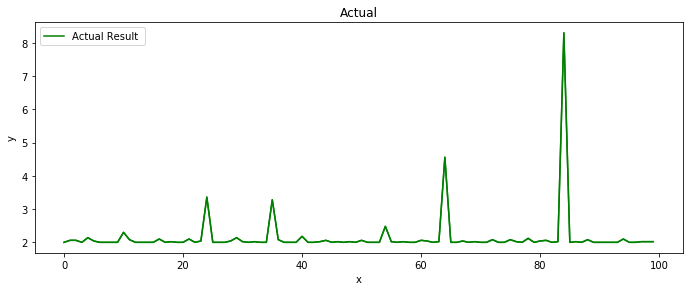

In [61]:
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 1.5, 0.8]) # left, bottom, width, height (range 0 to 1)


axes.plot( np.arange(100),ytest[0:100], 'g')
axes.plot( np.arange(100),ytest[0:100],'g', label="Actual Result ")


axes.legend(loc=2); # upper left corner
axes.set_xlabel('x')
axes.set_ylabel('y')
labels=['1','2','3','4','5','6','7','8','9','10']
axes.set_yticklabels(labels)
axes.set_title('Actual')

Text(0.5,1,'Predict using Linear')

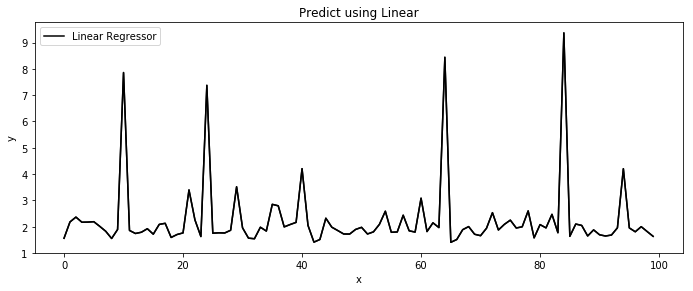

In [52]:
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 1.5, 0.8]) # left, bottom, width, height (range 0 to 1)

axes.plot( np.arange(100),yfit[0:100], 'black')

axes.plot( np.arange(100),yfit[0:100],'black', label="Linear Regressor")
axes.legend(loc=2); # upper left corner

axes.set_xlabel('x')
axes.set_ylabel('y')
labels=['1','2','3','4','5','6','7','8','9','10']
axes.set_yticklabels(labels)
axes.set_title('Predict using Linear')

Text(0.5,1,'linear actual $ predict overall')

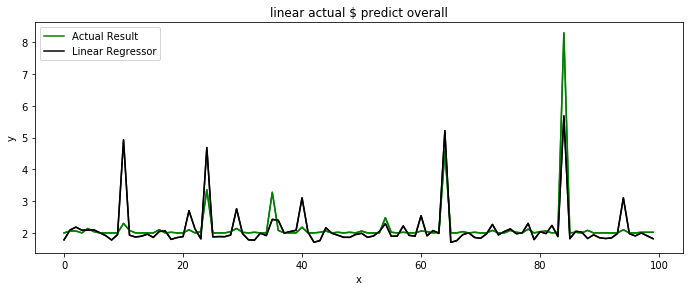

In [53]:
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 1.5, 0.8]) # left, bottom, width, height (range 0 to 1)


axes.plot( np.arange(100),ytest[0:100], 'g')
axes.plot( np.arange(100),yfit[0:100], 'black')

axes.plot( np.arange(100),ytest[0:100],'g', label="Actual Result ")
axes.plot( np.arange(100),yfit[0:100],'black', label="Linear Regressor")

axes.legend(loc=2); # upper left corner
axes.set_xlabel('x')
axes.set_ylabel('y')
labels=['1','2','3','4','5','6','7','8','9','10']
axes.set_yticklabels(labels)
axes.set_title('linear actual $ predict overall')

In [54]:
print ytrain.shape

(139708L,)


In [55]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))


In [56]:
print Xtrain.shape
print ytrain.shape
model = PolynomialRegression(2)
model.fit(Xtrain, ytrain)
yY_test = model.predict(Xtest)

#plt.scatter(Xtrain.ravel(), ytrain)
#plt.plot(Xtest.ravel(), yY_test)
#plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(Xtrain), ytrain)));

(139708L, 7L)
(139708L,)


# Mean Absolute Error in Polynomial

In [62]:
print np.mean(np.abs(yY_test-ytest))

8.60520184224078


Text(0.5,1,'polynomial predict  overall')

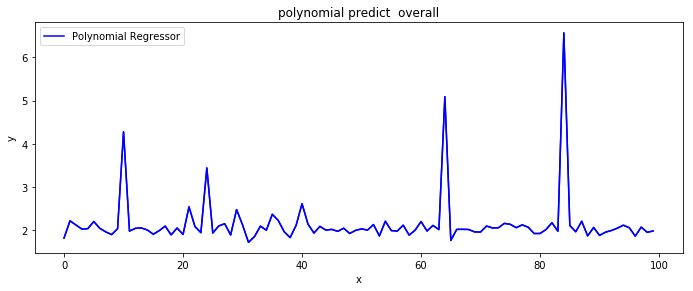

In [57]:
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 1.5, 0.8]) # left, bottom, width, height (range 0 to 1)



axes.plot( np.arange(100),yY_test[0:100], 'b')

axes.plot( np.arange(100),yY_test[0:100],'b', label="Polynomial Regressor")

axes.legend(loc=2); # upper left corner
axes.set_xlabel('x')
axes.set_ylabel('y')
labels=['1','2','3','4','5','6','7','8','9','10']
axes.set_yticklabels(labels)
axes.set_title('polynomial predict  overall')

Text(0.5,1,'polynomial actual $ predict overall')

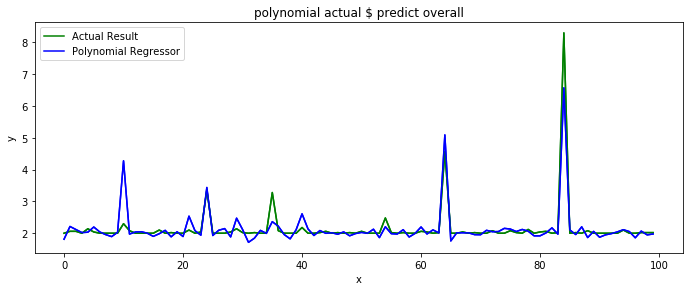

In [58]:
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 1.5, 0.8]) # left, bottom, width, height (range 0 to 1)


axes.plot( np.arange(100),ytest[0:100], 'g')
axes.plot( np.arange(100),yY_test[0:100], 'b')
axes.plot( np.arange(100),ytest[0:100],'g', label="Actual Result ")
axes.plot( np.arange(100),yY_test[0:100],'b', label="Polynomial Regressor")

axes.legend(loc=2); # upper left corner
axes.set_xlabel('x')
axes.set_ylabel('y')
labels=['1','2','3','4','5','6','7','8','9','10']
axes.set_yticklabels(labels)
axes.set_title('polynomial actual $ predict overall')

Text(0.5,1,'combine actual $ Predict')

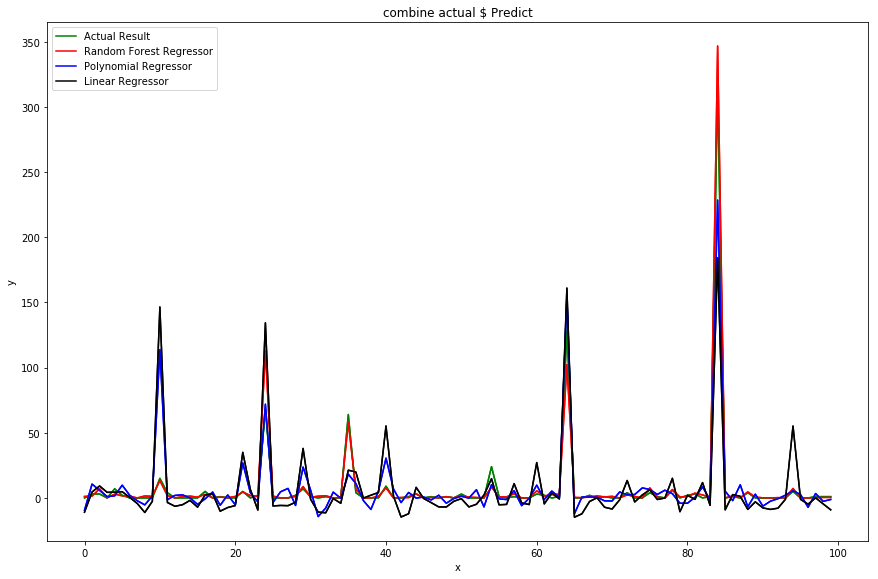

In [59]:
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 1.9, 1.8]) # left, bottom, width, height (range 0 to 1)

#axes.plot(x, ytest, label="y = x**3")

axes.plot( np.arange(100),y_test[0:100], 'r')
axes.plot( np.arange(100),ytest[0:100], 'g')
axes.plot( np.arange(100),yY_test[0:100], 'b')
axes.plot( np.arange(100),yfit[0:100], 'black')


axes.plot( np.arange(100),ytest[0:100],'g', label="Actual Result ")
axes.plot( np.arange(100),y_test[0:100],'r', label="Random Forest Regressor")
axes.plot( np.arange(100),yY_test[0:100],'b', label="Polynomial Regressor")
axes.plot( np.arange(100),yfit[0:100],'black', label="Linear Regressor")
axes.legend(loc=2); # upper left corner
axes.set_xlabel('x')
axes.set_ylabel('y')

axes.set_title('combine actual $ Predict')